# オートエンコーダー（一般画像）
* MNISTではなく、アニメ顔とかのオートエンコーダーを作ってみる
* 白黒だけど

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
from PIL import Image
from StringIO import StringIO
import math

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence

import six

import matplotlib.pyplot as plt

# chainer exampleに付属のdata.pyをimportする. mnistのダウンロードのため
import data

## GPU設定

In [2]:
gpu_flag = 0
if gpu_flag >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_flag >= 0 else np

## データのロード

In [3]:
# img_size
size = 96
# image path
image_dir = "./images/anime_face"
# load images
fs = os.listdir(image_dir)
dataset = []
for fn in fs:
    f = open('%s/%s'%(image_dir,fn), 'rb')
    img_bin = f.read()
    img = np.asarray(Image.open(StringIO(img_bin)).convert('L')).astype(np.float32).reshape(size*size)
    dataset.append(img)
    f.close()
dataset = np.asarray(dataset)
print("num_of_images : %s"%dataset.shape[0])

## 画素が（-1~1）の範囲に収まるように調整する関数の定義
def clip_img(x):
    return np.float32(-1 if x<(-1) else (1 if x>1 else x))

num_of_images : 10000


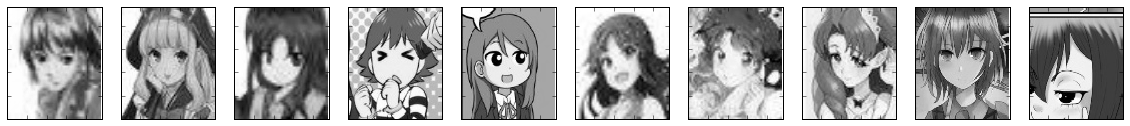

In [4]:
def draw_img_mc(data):
    size = 96
    n = data.shape[0]
    plt.figure(figsize=(n*2, 2))
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]             # flip vertical
        plt.xlim(0,size)
        plt.ylim(0,size)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
draw_img_mc( dataset[np.random.permutation( dataset.shape[0] )[:10]] )

In [5]:
N = dataset.shape[0]
train_rate = 0.7
N_train = int(N*train_rate)
N_test = N - N_train
print('N_dataset={}, N_train={}, N_test={}'.format(N, N_train, N_test))

# 正規化(0~1に)
dataset /= 255
# 訓練データとテストデータに分割
x_train, x_test = np.split(dataset,   [N_train])
print x_train.shape

N_dataset=10000, N_train=7000, N_test=3000
(7000, 9216)


## 学習パラメータの設定

In [38]:
batchsize = 100 # ミニバッチのサイズ
n_epoch = 50     # epoch数
n_latent = 1000   # 潜在変数の次元(DCGANで言うところのプライヤーベクトルの次元)
n_h = 5000   # 隠れ層のサイズ

# Optimizer(Adam)
al = 0.001
b1 = 0.9
b2 = 0.999

## モデルの定義

In [39]:
class AE(chainer.Chain):
    """AutoEncoder"""
    def __init__(self, n_in, n_latent, n_h):
        super(AE, self).__init__(
            ## ネットワーク構造の定義
            # encoder
            le1=L.Linear(n_in, n_h),
            le2=L.Linear(n_h, n_latent),
            bne1=L.BatchNormalization(n_h), 
            # decoder
            ld1=L.Linear(n_latent, n_h),
            ld2=L.Linear(n_h, n_in),
            bnd1=L.BatchNormalization(n_h), 
        )

    def __call__(self, x, sigmoid=True):
        """AutoEncoder"""
        # 下記、encodeとdecodeの中身をこの中に書いても良いがencodeとｄｅｃｏｄｅは他でも使うので再利用性を高めるために
        return self.decode(self.encode(x), sigmoid)
    
    def encode(self, x):
        # 推論モデル, 中間表現のベクトルqを学習
        h1 = F.relu(self.bne1(self.le1(x)))
        z = F.relu(self.le2(h1))
        return z

    def decode(self, z, sigmoid=True):
        # 中間表現ベクトルqを入力として(z), 画像を生成
        h1 = F.relu(self.bnd1(self.ld1(z)))
        h2 = self.ld2(h1)
        if sigmoid:
            return F.sigmoid(h2)
        else:
            return h2

    def get_loss_func(self, C=1.0, k=1, train=True):
        def lf(x):
            z = self.encode(x)
            # reconstruction loss
            #self.rec_loss = F.mean_squared_error(x, self.decode(z))
            self.rec_loss = F.bernoulli_nll(x, self.decode(z, sigmoid=False)) / (batchsize)
            # total_loss vanilla AEの場合はreconstruction lossとtotal lossは一緒
            self.loss = self.rec_loss
            return self.loss
        return lf

## Optimizerの設定

In [40]:
# モデルの設定
model = AE(size*size, n_latent, n_h) # VAE(n_in, n_latent, n_h) 
if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model.to_gpu()
xp = np if gpu_flag < 0 else cuda.cupy

# Optimizerを定義する
optimizer = optimizers.Adam(alpha=al, beta1=b1, beta2=b2)
optimizer.setup(model)

## 訓練の実行

In [41]:
loss_arr = []
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    
    # training
    ## 訓練データのsampler
    perm = np.random.permutation(N_train)
    ## lossのbuffer
    sum_loss = 0       # total loss
    sum_rec_loss = 0   # reconstruction loss
    ## バッチ学習
    for i in six.moves.range(0, N_train, batchsize):
        x = chainer.Variable(xp.asarray(x_train[perm[i:i + batchsize]])) # バッチ分のデータの抽出
        
        model.zerograds()
        loss = model.get_loss_func()(x)
        loss.backward()
        optimizer.update()
        
        sum_loss += float(model.loss.data) * len(x.data)

    print('train mean loss={}'.format(sum_loss / N_train))
    loss_arr.append(float(sum_loss)/N_train)

('epoch', 1)
train mean loss=5479.70914481
('epoch', 2)
train mean loss=5219.36826172
('epoch', 3)
train mean loss=5130.1589774
('epoch', 4)
train mean loss=5072.00954939
('epoch', 5)
train mean loss=5032.60458287
('epoch', 6)
train mean loss=5007.83189872
('epoch', 7)
train mean loss=4984.27449777
('epoch', 8)
train mean loss=4954.83475167
('epoch', 9)
train mean loss=4941.7949986
('epoch', 10)
train mean loss=4922.74275251
('epoch', 11)
train mean loss=4917.80171596
('epoch', 12)
train mean loss=4910.36441127
('epoch', 13)
train mean loss=4892.74763532
('epoch', 14)
train mean loss=4874.89003209
('epoch', 15)
train mean loss=4880.77429548
('epoch', 16)
train mean loss=4862.52380022
('epoch', 17)
train mean loss=4849.59983956
('epoch', 18)
train mean loss=4844.45924944
('epoch', 19)
train mean loss=4834.89382673
('epoch', 20)
train mean loss=4826.06120257
('epoch', 21)
train mean loss=4819.13011998
('epoch', 22)
train mean loss=4817.65144392
('epoch', 23)
train mean loss=4807.00771484

## 結果の可視化

[]

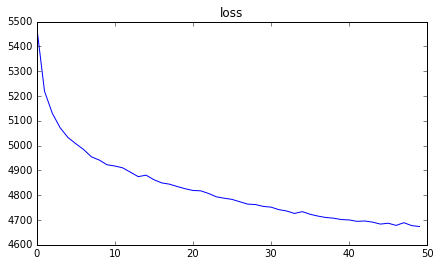

In [42]:
## lossグラフ
plt.figure(figsize=(7,4))
plt.plot(range(len(loss_arr)), loss_arr, color="#0000FF")
plt.title("loss")
plt.plot()

[3440 5520 4672 5800 5615 3917 1450 5253 5861  703]
input image


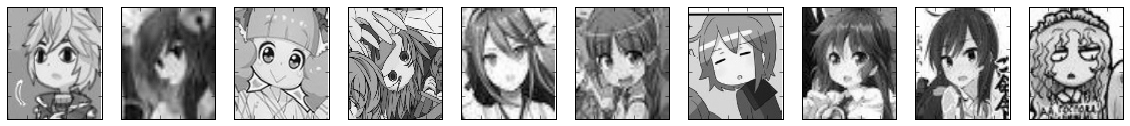

reconstruction image


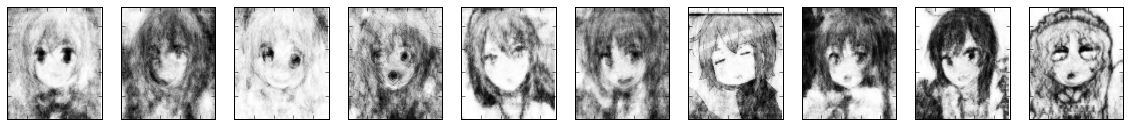

In [43]:
## 描画テスト (Closed test)
test_ind = np.random.permutation(N_train)[:10]
print test_ind
test = chainer.Variable(xp.asarray(x_train[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_mc(x_train[test_ind])

print "reconstruction image"
draw_img_mc(y.data.get())


[1276 1775 2996 1200 1773 1425  283 2750 2495  135]
input image


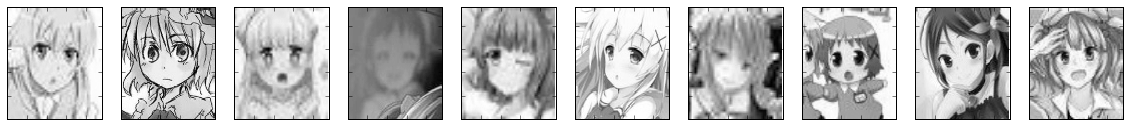

reconstruction image


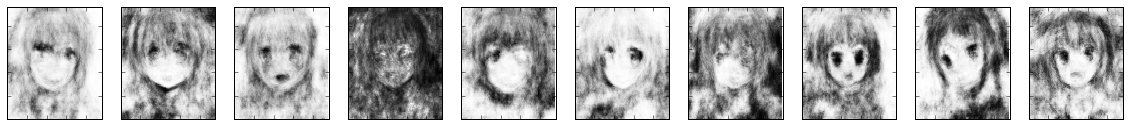

In [44]:
## 描画テスト (Open test) 
test_ind = np.random.permutation(N_test)[:10]
print test_ind
test = chainer.Variable(xp.asarray(x_test[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_mc(x_test[test_ind])

print "reconstruction image"
draw_img_mc(y.data.get())

## 中間層の状態の確認

In [45]:
# 中間層の状態をプロットする
def draw_weight(data, size=96, N=100):
    # サンプラー
    n = N
    n_col = int(math.ceil(N / 10))
    indexes = np.random.permutation( len(data) )[:n]
    size = size
    plt.figure(figsize=(10*2, n_col*2))
    # plot
    cnt = 1
    for idx in indexes:
        plt.subplot(n_col, 10, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]
        plt.xlim(0, size-1)
        plt.ylim(0, size-1)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.title("{0}".format(idx), size=9)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
    return indexes

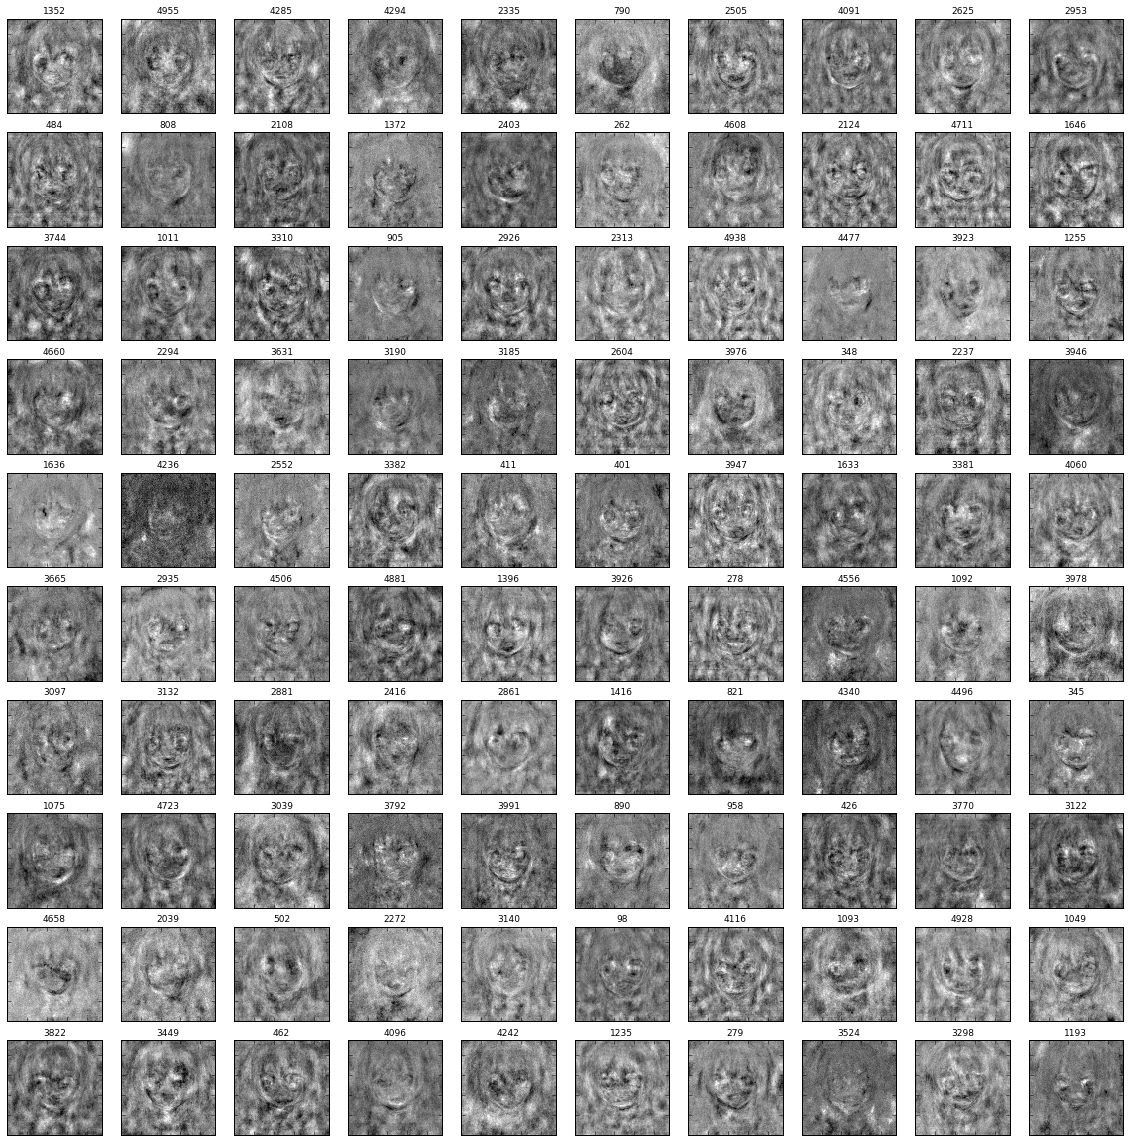

In [46]:
# 入力層の次の中間層
idxs = draw_weight(model.le1.W.data.get(), N=100)

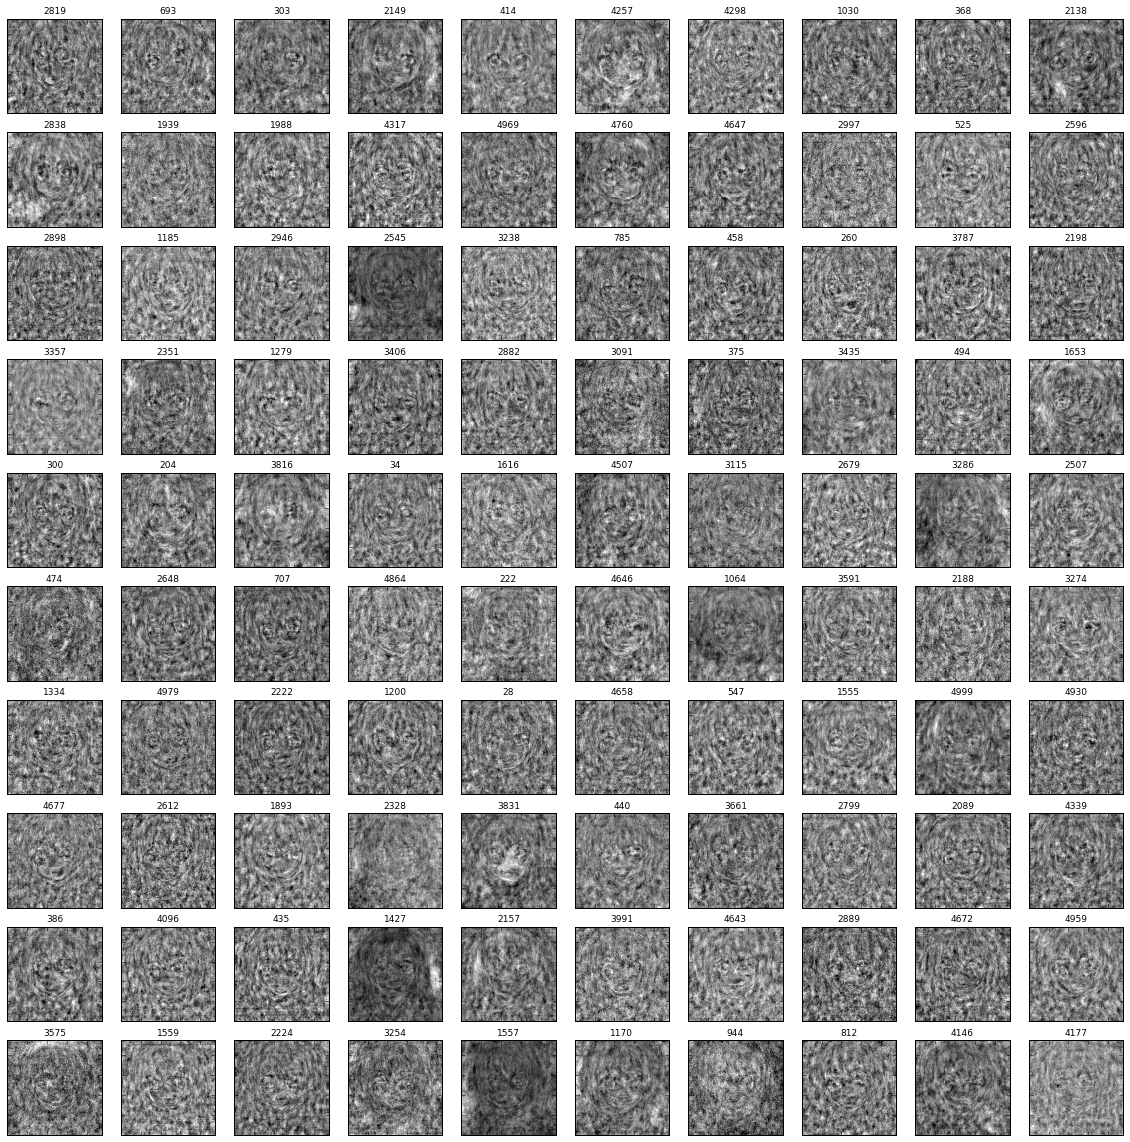

In [47]:
# 出力層の手前
idx = draw_weight(model.ld2.W.data.get().T, N=100)